# Aprendizaje no supervisado

## 1. Librerias

In [146]:
import pandas as pd
import numpy as np
import io
import warnings
import matplotlib.pyplot as plt
import datetime
import sklearn.metrics
%matplotlib inline
warnings.filterwarnings('ignore')
import seaborn as sb
from sklearn.model_selection import KFold
from sklearn import tree
from sklearn.metrics import accuracy_score
from sklearn.model_selection import KFold
from sklearn.tree import export_text
from IPython.display import Image as PImage
from subprocess import check_call
from PIL import Image, ImageDraw, ImageFont
from sklearn.ensemble import RandomForestClassifier
from sklearn.datasets import make_classification
from matplotlib import pyplot
from sklearn.ensemble import ExtraTreesClassifier
from sklearn import preprocessing 
from src.utils import load_examples, plot_scatter, plot_silhouette
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans
from sklearn.metrics import mean_squared_error
from sklearn.cluster import DBSCAN
from sklearn.model_selection import train_test_split

## 2. Datos

In [147]:
data = pd.read_csv('data.csv')
data['stays_nights']=data.stays_in_weekend_nights+data.stays_in_week_nights
data=data.drop(['stays_in_weekend_nights','stays_in_week_nights'],axis=1)
data.describe()

,Unnamed: 0,is_canceled,lead_time,arrival_date_year,arrival_date_week_number,arrival_date_day_of_month,adults,children,babies,is_repeated_guest,...,meal_FB,meal_HB,meal_SC,meal_Undefined,deposit_type_Non Refund,deposit_type_Refundable,reserverd/assigned,customer_type_Group,customer_type_Transient-Party,stays_nights
count,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,...,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000
mean,14999.500000,0.368367,8.280793,2016.156167,27.144700,15.785733,1.863632,0.106705,0.007900,0.032400,...,0.006100,0.122200,0.090733,0.009367,0.120433,0.001200,0.872467,0.004733,0.960500,3.440500
std,8660.398374,0.482370,2.027570,0.706490,13.649126,8.800606,0.635565,0.403716,0.105062,0.177063,...,0.077865,0.327522,0.287234,0.096329,0.325473,0.034621,0.333575,0.068637,0.194785,2.593791
min,0.000000,0.000000,0.763433,2015.000000,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,7499.750000,0.000000,7.664083,2016.000000,16.000000,8.000000,2.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,1.000000,2.000000
50%,14999.500000,0.000000,8.326678,2016.000000,27.000000,16.000000,2.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,1.000000,3.000000
75%,22499.250000,1.000000,9.003887,2017.000000,38.000000,23.000000,2.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,1.000000,4.000000
max,29999.000000,1.000000,17.690502,2017.000000,53.000000,31.000000,55.000000,3.000000,10.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,69.000000


## 3. K-means
Método de agrupamiento, que tiene como objetivo la partición de un conjunto de datos en k grupos. 
Los grupos se realizan minimizando la suma de distancias entre cada objeto y el centroide de su cluster. Se suele usar la distancia cuadrática.

Lo vamos a separar en dos partes:
1. Primero vamos a usar como objetivo la variabla is_canceled, por lo que vamos a intentar clasificar nuestros datos en dos clusters y ver el resultado.

2. Despúes vamos a ver cual es el número más óptimo de clusters utilizando como objetivo la variable stays_nights, para entonces ver si tiene sentido separar esa variable en varias subclases en función del número de clusters 

### Variable Objetivo: is_canceled

Vamos a normalizar los datos y usar dos clusters para intentar clasificar en función de los dos valores de nuestra variable objetivo:

In [87]:
X = data.drop(['is_canceled', 'Unnamed: 0'], axis=1).values
Y = data.is_canceled

In [88]:
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.33, random_state=1)
print('Train', X_train.shape, y_train.shape)
print('Test', X_test.shape, y_test.shape)

Train (20100, 27) (20100,)
Test (9900, 27) (9900,)


In [89]:
scaler = preprocessing.StandardScaler().fit(X_train)
Xs_train = scaler.transform(X_train)

scaler = preprocessing.StandardScaler().fit(X_test)
Xs_test = scaler.transform(X_test)

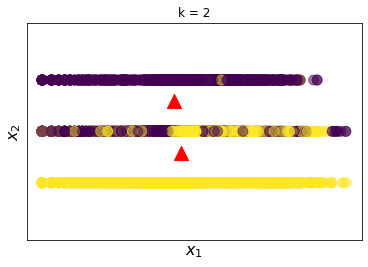

In [90]:
k = 2
kmeans = KMeans(n_clusters = k)
kmeans.fit(Xs_train) 
centroids = kmeans.cluster_centers_
cluster_labels = kmeans.labels_
plot_scatter(Xs_train,'k = ' + str(k), cluster_labels, centroids)
plt.show()

In [91]:
k = 2
kmeans = KMeans(n_clusters=k).fit(Xs_train)
print("Inertia: {}".format(kmeans.inertia_))

Inertia: 504810.8020027893


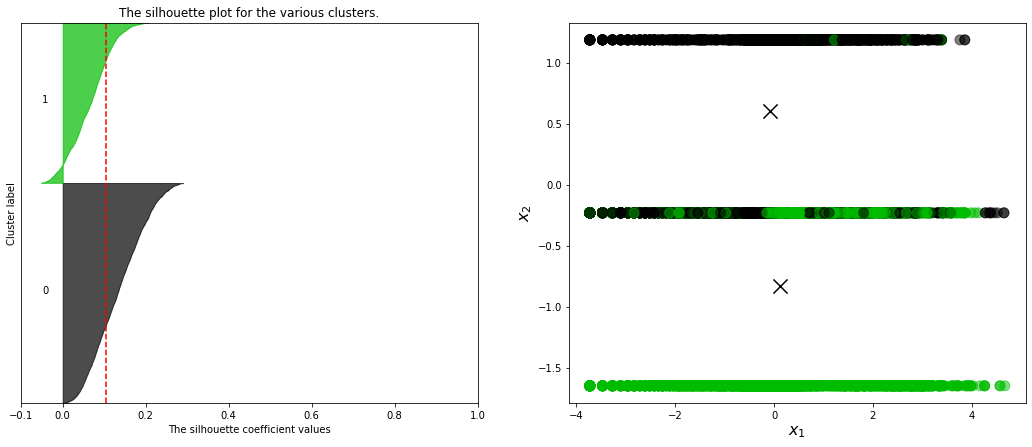

In [92]:
k = 2
kmeans = KMeans(n_clusters=k).fit(Xs_train)
plot_silhouette(Xs_train,k,kmeans.labels_,kmeans.cluster_centers_)

Se puede ver que no funciona muy bien, ya que obtenemos un inertia muy alto y casi todos los datos pertenecen al mismo grupo.

Ahora vamos a calcular el RMSE

In [93]:
Y_predicted = kmeans.predict(Xs_test)
Y_predicted

array([0, 1, 0, ..., 1, 1, 1], dtype=int32)

In [94]:
print("El RSMS obtenido es: {}".format(mean_squared_error(y_test, Y_predicted, squared=False)))

El RSMS obtenido es: 0.6966731912120169


Vemos que el RMSE es 0.69, lo que es un valor alto con respecto a los valores medios de la variable (0.36)

In [95]:
sklearn.metrics.confusion_matrix(y_test,Y_predicted)

array([[3589, 2709],
       [2096, 1506]])

In [96]:
print("Accuracy: {}".format(sklearn.metrics.accuracy_score(y_test, Y_predicted)))
print("Recall: {}".format(sklearn.metrics.recall_score(y_test, Y_predicted)))
print("Precision: {}".format(sklearn.metrics.precision_score(y_test, Y_predicted)))
print("F1 Score: {}".format(sklearn.metrics.f1_score(y_test, Y_predicted)))

Accuracy: 0.5146464646464647
Recall: 0.4181010549694614
Precision: 0.3572953736654804
F1 Score: 0.3853140591019573


La conclusión es que no se ha conseguido una buena clasificación, ya que hemos obtenido un RMSE muy alto y las variables usadas para evaluar el modelo no han dado buenos resultados.

### Variable Objetivo: stays_nights
Normalizamos los datos y aplicamos TSNE para ver los datos en dos dimensiones:

In [119]:
X = data.drop(['stays_nights', 'Unnamed: 0'], axis=1).values
Y = data.stays_nights

In [120]:
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.33, random_state=1)
print('Train', X_train.shape, y_train.shape)
print('Test', X_test.shape, y_test.shape)

Train (20100, 27) (20100,)
Test (9900, 27) (9900,)


In [121]:
columns = data.drop(['stays_nights', 'Unnamed: 0'], axis=1).columns

In [122]:
scaler = preprocessing.StandardScaler().fit(X_train)
Xs_train = scaler.transform(X_train)

scaler = preprocessing.StandardScaler().fit(X_test)
Xs_test = scaler.transform(X_test)

Aplicamos TSNE para ver una representación de los datos:

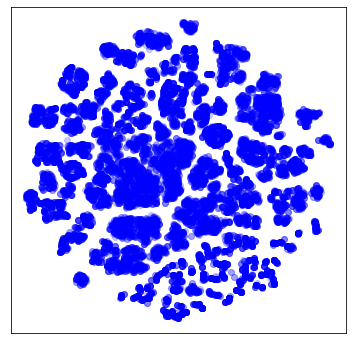

In [123]:
Xs = TSNE(n_components=2, random_state=0).fit_transform(Xs_train)
plt.figure(figsize=(6, 6))
plt.scatter(Xs[:, 0], Xs[:, 1], c = 'b', marker='o', alpha=0.2)
plt.xticks([])
plt.yticks([])
plt.show();

Se puede ver no hay grandes distancias que separen unos grupos de otros.


Aún así,vamos a ver cual es el número de cluster más óptimo para nuestros datos.

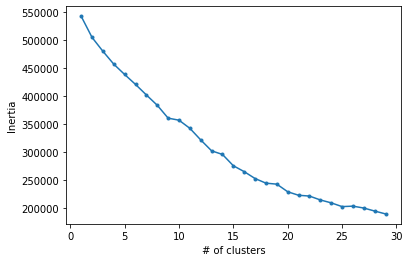

In [126]:
K = range(1,30)

inertia = []
for k in K:
    kmeans = KMeans(n_clusters=k).fit(Xs_train)
    inertia.append(kmeans.inertia_)
    
plt.plot(K,inertia,'.-')
plt.xlabel('# of clusters')
plt.ylabel('Inertia')
plt.show()

Vemos que el inertia podría seguir bajando, pero no tiene sentido dividir en 30 clusters cuando la variable objetivo se mueve en valores bajo (su media es 3.4), por lo que nos quedamos con K=20

Vamos a ver las dimensiones de los distintos clusters para intentar encontrar alguna relación:

Inertia: 226690.08674907254
Cluster sizes k-means: [ 684 1554 1776 3587  134 2226 3172  202 1682   27 1034   88   32 2183
   31  573  896    1  119   99]
Cluster distances k-means: [1073031.69, 706564.42, 702955.04, 601772.2, 2303441.33, 757161.92, 618220.86, 2574799.34, 776887.64, 15624682.17, 877484.8, 5608300.24, 9407596.79, 615728.95, 11720227.36, 1227064.6, 870804.6, 162880845.01, 3748401.31, 3188861.47]


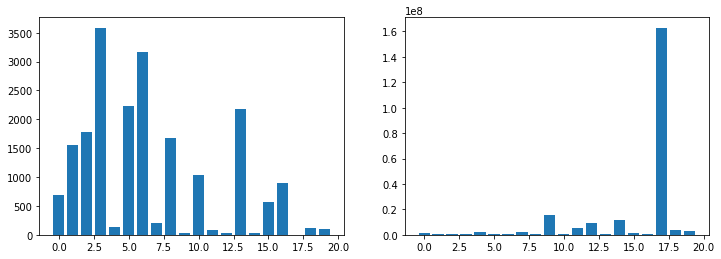

In [127]:
k = 20
kmeans = KMeans(n_clusters=k, random_state=0)
model_fit = kmeans.fit_predict(Xs_train)

print("Inertia: {}".format(kmeans.inertia_))

print("Cluster sizes k-means: {}".format(np.bincount(model_fit)))

distances = []
for c in kmeans.cluster_centers_:
    d = np.sum( np.sum((Xs_train - c) ** 2, axis=1) ) 
    distances.append(d.round(2))
    
print("Cluster distances k-means: {}".format(distances))

plt.figure(figsize=(12,4))
plt.subplot(121)
plt.bar(range(k),np.bincount(model_fit))

plt.subplot(122)
plt.bar(range(k),distances)
plt.show()

Podemos ver que en los clusters con más elementos, son en los que estos están más centrados.


Ahora vamos a ver los datos del cluster con datos más centrados y los datos del cluster con datos más separados:

In [128]:
def close_to_far_from_center(x,centroid, n=5):
    distance = np.sum((x - centroid) ** 2, axis=1)
    print('Close to center')
    display(pd.DataFrame(X[np.argsort(distance)[:n]], columns= columns))
    print('Far from center')
    display(pd.DataFrame(X[np.argsort(distance)[-n:]], columns= columns))

In [129]:
close_to_far_from_center(Xs_train,kmeans.cluster_centers_[9])

Close to center


,is_canceled,lead_time,arrival_date_year,arrival_date_week_number,arrival_date_day_of_month,adults,children,babies,is_repeated_guest,previous_cancellations,...,hotel_Resort Hotel,meal_FB,meal_HB,meal_SC,meal_Undefined,deposit_type_Non Refund,deposit_type_Refundable,reserverd/assigned,customer_type_Group,customer_type_Transient-Party
0,1.0,5.357915,2016.0,23.0,1.0,2.0,0.0,0.0,0.0,0.0,...,1.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0
1,0.0,7.572828,2015.0,38.0,14.0,2.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
2,0.0,7.066115,2016.0,9.0,22.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0
3,0.0,7.680557,2016.0,17.0,17.0,2.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0
4,0.0,8.420304,2015.0,44.0,26.0,2.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0


Far from center


,is_canceled,lead_time,arrival_date_year,arrival_date_week_number,arrival_date_day_of_month,adults,children,babies,is_repeated_guest,previous_cancellations,...,hotel_Resort Hotel,meal_FB,meal_HB,meal_SC,meal_Undefined,deposit_type_Non Refund,deposit_type_Refundable,reserverd/assigned,customer_type_Group,customer_type_Transient-Party
0,1.0,7.865361,2016.0,36.0,30.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0
1,0.0,8.032036,2015.0,33.0,9.0,2.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0
2,1.0,8.060906,2016.0,34.0,19.0,2.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0
3,0.0,0.763433,2016.0,13.0,21.0,2.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0
4,0.0,6.097240,2015.0,32.0,2.0,2.0,1.0,0.0,0.0,0.0,...,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0


Como podemos ver, los datos más cercanos son bastante parecidos en los datos más centrados

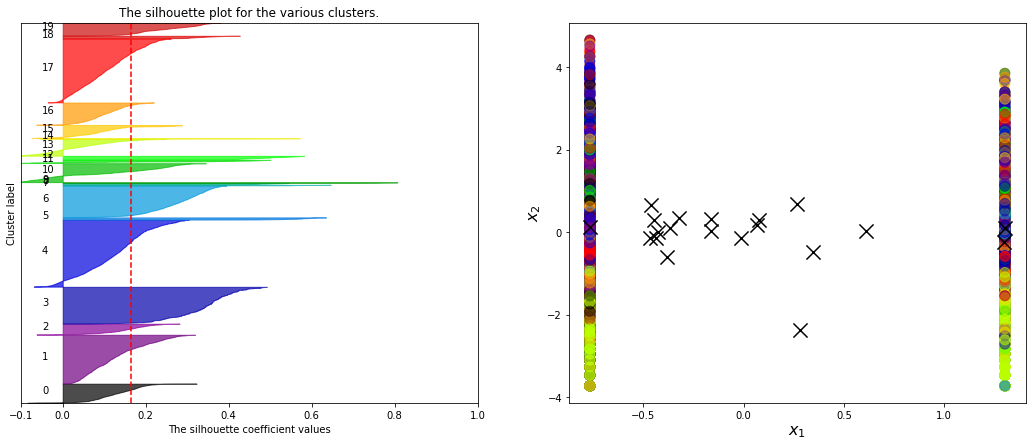

In [131]:
k = 20
kmeans = KMeans(n_clusters=k).fit(Xs_train)
plot_silhouette(Xs_train,k,kmeans.labels_,kmeans.cluster_centers_)

In [133]:
Y_predicted = kmeans.predict(Xs_test)
print("El RSMS obtenido es: {}".format(mean_squared_error(y_test, Y_predicted, squared=False)))

El RSMS obtenido es: 8.243705894116243


Vemos que tiene un RMSE alto para el rango en el que se mueve nuestra variable objetivo (es más del doble que la media).

In [141]:
print("Accuracy: {}".format(sklearn.metrics.accuracy_score(y_test, Y_predicted)))
print("Recall: {}".format(sklearn.metrics.recall_score(y_test, Y_predicted, average='weighted')))
print("Precision: {}".format(sklearn.metrics.precision_score(y_test, Y_predicted, average='weighted')))
print("F1 Score: {}".format(sklearn.metrics.f1_score(y_test, Y_predicted, average='weighted')))

Accuracy: 0.08808080808080808
Recall: 0.08808080808080808
Precision: 0.1873703321960087
F1 Score: 0.10341668831323397


La conclusión es que la separación por clusters no ha sido eficiente, ya los grupos no están lo suficientemente diferenciados, el RMSE que hemos obtenido es alto y todas las métricas usadas para evaluarlo han dado malos resultados.


Vamos a utilizar DB-SCAN para dividir nuestros datos en grupos:

## 4. DB-SCAN
Al contrario de la estrategia seguida por k-Means, DBSCAN (Density-Based Spatial Clustering of Applications with Noise) no presupone clusters convexos, sino que se basa en la densidad de las muestras para identificar los clusters.

Vamos a probar DB-SCAN con distintos valores de eps y siempre min_samples=10

### Variable Objetivo: is_canceled

Vamos a normalizar los datos y aplicamos DB-SCAN tratando de encontrar dos clusters, y entonces ver cuantos elementos hay en cada uno:

In [148]:
X = data.drop(['is_canceled', 'Unnamed: 0'], axis=1).values
Y = data.is_canceled
scaler = preprocessing.StandardScaler().fit(X)
Xs = scaler.transform(X)

In [149]:
for eps in [28, 29, 30]:
    print("\neps={}".format(eps))
    dbscan = DBSCAN(eps=eps, min_samples=10)
    labels = dbscan.fit_predict(Xs)
    print("Number of clusters: {}".format(len(np.unique(labels))))
    print("Cluster sizes: {}".format(np.bincount(labels + 1)))


eps=28
Number of clusters: 3
Cluster sizes: [    6 29958    36]

eps=29
Number of clusters: 2
Cluster sizes: [    6 29994]

eps=30
Number of clusters: 2
Cluster sizes: [    6 29994]


Como podemos observar, se obtienen dos clusters pero muy muy desbalanceados.

### Variable Objetivo: stays_nights
Normalizamos los datos y aplicamos DB-SCAN:

In [ ]:
X = data.drop(['stays_nights', 'Unnamed: 0'], axis=1).values
Y = data.stays_nights
columns = data.drop(['stays_nights', 'Unnamed: 0'], axis=1).columns
scaler = preprocessing.StandardScaler().fit(X)
Xs = scaler.transform(X)

In [ ]:
for eps in [1, 3, 5, 6, 7, 8, 9]:
    print("\neps={}".format(eps))
    dbscan = DBSCAN(eps=eps, min_samples=10)
    labels = dbscan.fit_predict(Xs)
    print("Number of clusters: {}".format(len(np.unique(labels))))
    print("Cluster sizes: {}".format(np.bincount(labels + 1)))

Se puede ver que salen grupos muy desbalanceados en los que claramente hay un cluster con un alto porcentaje de todos los datos.

## 5. Árboles de decisión

Un árbol de decisión es una estructura arbórea similar a un diagrama de flujo en la que un nodo interno representa una característica (o atributo), la rama representa una regla de decisión y cada nodo de hoja representa el resultado. El nodo superior de un árbol de decisión se conoce como nodo raíz. Aprende a dividir en función del valor del atributo. La partición del árbol se denomina partición recursiva. Esta estructura similar a un diagrama de flujo le ayuda en la toma de decisiones. Se visualiza como un diagrama de flujo que imita fácilmente el pensamiento a nivel humano. Por eso los árboles de decisión son fáciles de entender e interpretar.

El árbol de decisión es un algoritmo de caja blanca de ML. Comparte la lógica interna de la toma de decisiones, que no está disponible en el tipo de algoritmos de caja negra como la red neuronal. Su tiempo de entrenamiento es más rápido en comparación con el algoritmo de la red neuronal. La complejidad temporal de los árboles de decisión es una función del número de registros y del número de atributos en los datos dados. El árbol de decisión es un método no paramétrico, que no depende de supuestos de distribución de probabilidad. Los árboles de decisión pueden manejar datos de alta dimensión con buena precisión.


In [16]:
data_tree = pd.read_csv('simple-hotels.csv',delimiter=",")

In [17]:
drop_elements=["arrival_date_week_number","arrival_date_year","arrival_date_day_of_month","agent","company","reservation_status","reservation_status_date","arrival_date_month","country"]
data_tree = data_tree.drop(drop_elements,axis=1)

Primero observamos cómo de balanceada está la clase que queremos precedir o clasificar, ya que, si esta se eencuentra muy desbalanceada en favor de alguna de las clases puede afectar la precisión de la predicción. Como observamos abajo, la clase "0" (no se cancela) es, en proporción, 1.6 veces mayor que la calse "1" (no se cancela).

In [18]:
data_tree.groupby("is_canceled").size()

is_canceled
0    6249
1    3751
dtype: int64

A continuación, el algoritmo de decision tree de scikit-learn no acepta clases categóricas etiquetadas como strings , por lo que hay que hacer su conversión numérica:

# Revisar

In [25]:
data_tree['hotel_encoded'] = data_tree['hotel'].map({'City Hotel': 0, 'Resort Hotel': 1, '': 2}).astype(int)
data_tree['meal_encoded'] = data_tree['meal'].map({'BB': 0, 'SC': 1, 'HB': 2, 'FB': 3, 'Undefined': 4, '': 5}).astype(int)
data_tree['market_seg_encoded'] = data_tree['market_segment'].map({'Online TA': 0, 'Direct': 1, 'Groups': 2, 'Offline TA/TO': 3, 'Corporate': 4, 'Aviation': 5, 'Complementary': 6, '':7}).astype(int)
data_tree['dist_chnl_encoded'] = data_tree['distribution_channel'].map({'TA/TO': 0, 'Direct': 1, 'Corporate': 2, 'GDS': 3, '': 4}).astype(int)
data_tree['res_room_type_encoded'] = data_tree['reserved_room_type'].map({'D': 0, 'A': 1, 'E': 2, 'F': 3, 'G': 4, 'C': 5, 'H': 6,'B': 7, 'P': 8, 'L': 9, '':10}).astype(int)
data_tree['asig_room_type_encoded'] = data_tree['assigned_room_type'].map({'D': 0, 'A': 1, 'E': 2, 'F': 3, 'G': 4, 'C': 5, 'H': 6,'B': 7, 'P': 8, 'K': 9, '':10, 'I': 12}).astype(int)
data_tree['depo_type_encoded'] = data_tree['deposit_type'].map({'No Deposit': 0, 'Non Refund': 1, 'Refundable': 2, '': 3}).astype(int)
data_tree['cust_type_encoded'] = data_tree['customer_type'].map({'Transient': 0, 'Transient-Party': 1, 'Contract': 2, 'Group': 3, '': 4}).astype(int)

Transformadas las variables categóricas en variables categóricas numéricas, las añadimos al dataset utilizado para alimentar al modelo.

In [26]:
drop_elements=["hotel","meal","market_segment","distribution_channel","reserved_room_type","assigned_room_type","deposit_type","customer_type"]
data_tree_encoded = data_tree.drop(drop_elements,axis=1)

Antes de entrenar el modelo, queremos saber cuál es la profundidad apropiada del árbol, para ello, entrenamos varios árboles con distintos valores de profundidad y analizamos su precisión:

In [27]:
cv = KFold(n_splits=10) # Numero deseado de "folds" que haremos
accuracies = list()
max_attributes = len(list(data_tree_encoded))
depth_range = range(1, max_attributes + 1)

for depth in depth_range:
    fold_accuracy = []
    tree_model = tree.DecisionTreeClassifier(criterion='entropy',
                                             min_samples_split=50,
                                             min_samples_leaf=25,
                                             max_depth = depth,
                                             class_weight={1:1.6})
    for train_fold, valid_fold in cv.split(data_tree_encoded):
        f_train = data_tree_encoded.loc[train_fold] 
        f_valid = data_tree_encoded.loc[valid_fold] 
 
        model = tree_model.fit(X = f_train.drop(['is_canceled'], axis=1), 
                               y = f_train["is_canceled"]) 
        valid_acc = model.score(X = f_valid.drop(['is_canceled'], axis=1), 
                                y = f_valid["is_canceled"]) # calculamos la precision con el segmento de validacion
        fold_accuracy.append(valid_acc)
 
    avg = sum(fold_accuracy)/len(fold_accuracy)
    accuracies.append(avg)
    
# Mostramos los resultados obtenidos
df = pd.DataFrame({"Max Depth": depth_range, "Average Accuracy": accuracies})
df = df[["Max Depth", "Average Accuracy"]]
print(df.to_string(index=False))

 Max Depth  Average Accuracy
         1            0.7430
         2            0.7430
         3            0.7430
         4            0.7103
         5            0.8013
         6            0.8076
         7            0.8070
         8            0.8067
         9            0.7971
        10            0.7939
        11            0.7926
        12            0.7879
        13            0.7874
        14            0.7877
        15            0.7840
        16            0.7795
        17            0.7805
        18            0.7806
        19            0.7793
        20            0.7803
        21            0.7802
        22            0.7799
        23            0.7804


Vemos que con una profundidad entre 5 y 8 conseguimos superar un 80 % de precisión, nos decantamos por una profundidad de 6 en el árbol. Y entrenamos el modelo.

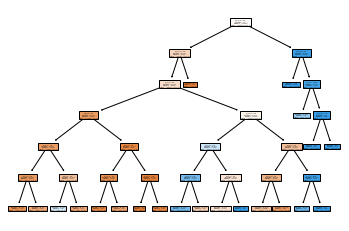

In [28]:
y_train = data_tree_encoded['is_canceled']
x_train = data_tree_encoded.drop(['is_canceled'], axis=1).values 
 
# Crear Arbol de decision con profundidad = 6
decision_tree = tree.DecisionTreeClassifier(criterion='entropy',
                                            min_samples_split=50,
                                            min_samples_leaf=25,
                                            max_depth = 6,
                                            class_weight={1:1.6})
decision_tree.fit(x_train, y_train)
r = export_text(decision_tree, feature_names=list(data_tree_encoded.drop(['is_canceled'], axis=1)))
tree.plot_tree(decision_tree, filled=True)
plt.show()

In [29]:
print(r)

|--- depo_type_encoded <= 0.50
|   |--- required_car_parking_spaces <= 0.50
|   |   |--- lead_time <= 8.50
|   |   |   |--- booking_changes <= 0.50
|   |   |   |   |--- stays_in_weekend_nights <= 1.50
|   |   |   |   |   |--- lead_time <= 3.50
|   |   |   |   |   |   |--- class: 0
|   |   |   |   |   |--- lead_time >  3.50
|   |   |   |   |   |   |--- class: 0
|   |   |   |   |--- stays_in_weekend_nights >  1.50
|   |   |   |   |   |--- adults <= 1.50
|   |   |   |   |   |   |--- class: 1
|   |   |   |   |   |--- adults >  1.50
|   |   |   |   |   |   |--- class: 0
|   |   |   |--- booking_changes >  0.50
|   |   |   |   |--- stays_in_week_nights <= 1.50
|   |   |   |   |   |--- market_seg_encoded <= 1.50
|   |   |   |   |   |   |--- class: 0
|   |   |   |   |   |--- market_seg_encoded >  1.50
|   |   |   |   |   |   |--- class: 0
|   |   |   |   |--- stays_in_week_nights >  1.50
|   |   |   |   |   |--- asig_room_type_encoded <= 1.50
|   |   |   |   |   |   |--- class: 0
|   |   |   |

## 6. Random Forest

In [31]:
cv = KFold(n_splits=8)
for train_fold, valid_fold in cv.split(data_tree_encoded):
        f_train = data_tree_encoded.loc[train_fold] 
        f_valid = data_tree_encoded.loc[valid_fold] 

x_train = f_train.drop(['is_canceled'], axis=1)
y_train = f_train["is_canceled"]
x_test = f_valid.drop(['is_canceled'], axis = 1)
y_test = f_valid['is_canceled']

#x_train, y_train = make_classification(n_samples=100, n_features=22,
                           #n_informative=2, n_redundant=0,
                            #random_state=0, shuffle=False)
clf = RandomForestClassifier(max_depth=6, random_state=0, oob_score=True, class_weight={1:1.6})
clf.fit(x_train, y_train)



RandomForestClassifier(class_weight={1: 1.6}, max_depth=6, oob_score=True,
                       random_state=0)

Entrenado el modelo del bosque de árboles, extraemos la importancia que cada variable aporta a la expliabilidad del modelo. Según este, las variables que más información sobre la respuesta tienen son: "depo_type_encoded", "lead_time", "total_of_special_requests", "previous_cancellations", "market_seg_encoded" y "cust_type_encoded".

In [33]:
print(clf.feature_importances_)

[1.64646028e-01 3.19423752e-03 7.63369035e-03 5.71307617e-03
 1.21975615e-03 6.74035868e-05 2.99747637e-03 7.30251116e-02
 9.24856535e-03 3.78326440e-02 2.57590862e-03 2.44179806e-02
 6.73644716e-02 9.61842723e-02 9.02919936e-03 1.68299944e-03
 6.40609988e-02 1.76084893e-02 5.10960097e-03 1.53159940e-02
 3.30134616e-01 6.09374795e-02]


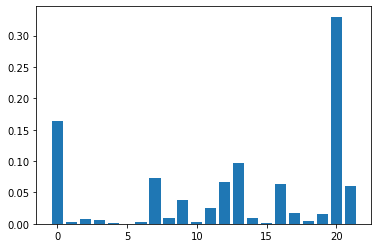

In [34]:
pyplot.bar(range(len(clf.feature_importances_)), clf.feature_importances_)
pyplot.show()

In [44]:
predictions_clf = clf.predict(x_test)
sklearn.metrics.confusion_matrix(y_test,predictions_clf)

array([[717,  70],
       [158, 305]], dtype=int64)

In [59]:
sklearn.metrics.accuracy_score(y_test, predictions_clf)

0.8176

In [45]:
sklearn.metrics.recall_score(y_test, predictions_clf)

0.6587473002159827

In [46]:
sklearn.metrics.precision_score(y_test, predictions_clf)

0.8133333333333334

In [56]:
sklearn.metrics.f1_score(y_test, predictions_clf)

0.7279236276849641

Este modelo de random forest obtiene un buen rendimiento en accuracy, clasifica bien respecto al total de casos. Sin embargo, no es tan bueno en recall, esto es, no es tan bueno prediciendo TP (True positives), tiene bastantes falsos negativos.
Respecto a precision score, el modelo da pocos falsos positivos y en cuanto al f1_score, se ve mermada por la no tan buena métrica de recall que tiene el modelo. 

### Algoritmo ExtraTreesClassifier

A continuación, entrenamos otro clasificador de random forest que tiene Scikit-learn el ExtraTreesClasifier(). En este random forest, da un giro de tuerca más a la aleatoriedad al establecer aleatoriamente los valores que dividen cada nodo/caraterísitca y escogiendo la división que mejor rendimiento de como regla de división.

Para este modelo las variable que más información aportan a este son: "lead_time", "adr", "depo_type_encoded", "stays_in_week_nights", "total_of_special_requests".

In [63]:
model = ExtraTreesClassifier()
model.fit(x_train,y_train)
print(model.feature_importances_)

[0.18888869 0.04716868 0.07538019 0.02503268 0.0122707  0.00213642
 0.00539756 0.03172106 0.00300665 0.0293792  0.00460701 0.13715629
 0.02710233 0.07283916 0.01797376 0.02482699 0.0460312  0.01835601
 0.02388568 0.03441833 0.13758201 0.03483939]


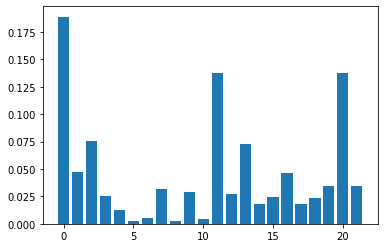

In [64]:
pyplot.bar(range(len(model.feature_importances_)), model.feature_importances_)
pyplot.show()

In [47]:
predictions_model = model.predict(x_test)
sklearn.metrics.confusion_matrix(y_test,predictions_model)

array([[648, 139],
       [128, 335]], dtype=int64)

In [48]:
sklearn.metrics.accuracy_score(y_test, predictions_model)

0.7864

In [49]:
sklearn.metrics.recall_score(y_test, predictions_model)

0.7235421166306696

In [50]:
sklearn.metrics.precision_score(y_test, predictions_model)

0.7067510548523207

In [57]:
sklearn.metrics.f1_score(y_test, predictions_model)

0.7150480256136605

Este modelo ExtraTreesClassifier tiene su mayor fortaleza en la accuracy_score, clasifica bien en general. Pero no tan bien como el modelo anterior. Sin embargo, en recall obtiene mejor rendimiento y en precision_score también es superado por e modelo anterior.
Se podría decir que este modelo no produce tantos falsos negativos (FN) pero a costa de reducir su precisión en los verdaderos positivos (TP). 
Sin embargo, ambos modelos mantienen un F1_score muy similar.